In [1]:
import torch
import tqdm
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from segmentation_models_pytorch.utils.meter import AverageValueMeter
from torch.utils.data import DataLoader, random_split
from utils.image_loading import load_training_images, load_groundtruth_images, load_test_images
from custom_datasets import Sat_Mask_Dataset_UPP_preprocessed
import albumentations as album
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
from torcheval.metrics.functional import multiclass_f1_score

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if GPU is available
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


## Extract the training data:

In [3]:
# Preprocessing function
preprocess_input = get_preprocessing_fn('efficientnet-b5', pretrained='imagenet')
preprocess_input =  album.Compose([album.Lambda(image=preprocess_input), ToTensorV2()])

In [4]:
# Load original data
original_data = {}
original_data["images"] = load_training_images()
original_data["masks"] = load_groundtruth_images()

In [5]:
# Load custom data for specified cities
city_names = ["boston", "nyc", "philadelphia", "austin"]
custom_data = {"images": [], "masks": []}
for name in city_names:
    custom_data["images"].extend(load_training_images(name))
    custom_data["masks"].extend(load_groundtruth_images(name))

In [6]:
# Create training datasets
custom_data_set = Sat_Mask_Dataset_UPP_preprocessed(custom_data["images"], custom_data["masks"], min_street_ratio=0.03, max_street_ratio=1.0, upp_preprocess=preprocess_input)
original_data_set = Sat_Mask_Dataset_UPP_preprocessed(original_data["images"], original_data["masks"],  upp_preprocess=preprocess_input)
print("After cleanup, the dataset now contains", len(custom_data_set), "images")

Initialized dataset, checked for min,max street ratio. Discarded %: 0.10242587601078167  num discarded: 1330
Initialized dataset, checked for min,max street ratio. Discarded %: 0.0  num discarded: 0
After cleanup, the dataset now contains 11655 images


### Print Images in different styles:
- Normal Satellite Image
- Corresponding Mask
- Preprocessed Satellite Image
- Preprocessed Mask

(400, 400, 3)


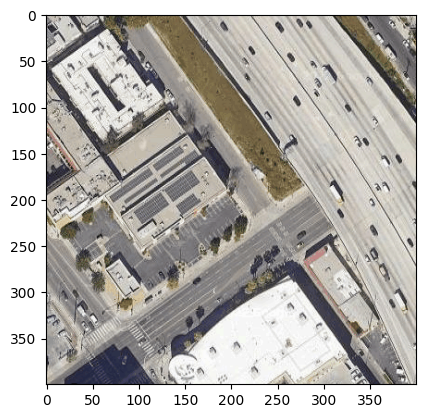

(400, 400, 3)


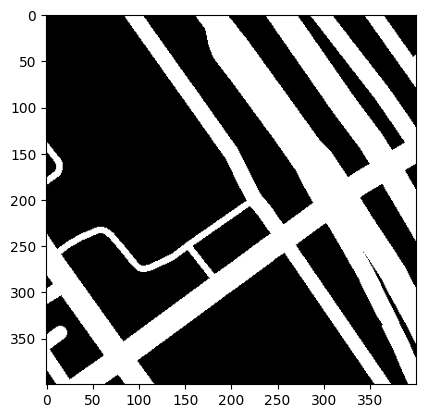

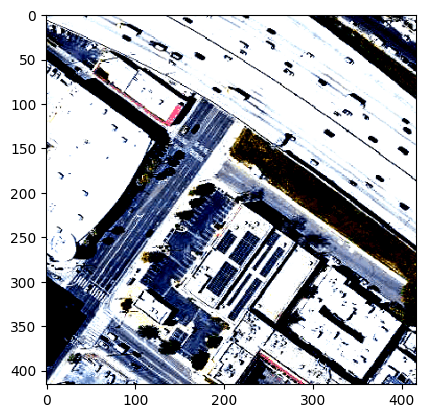

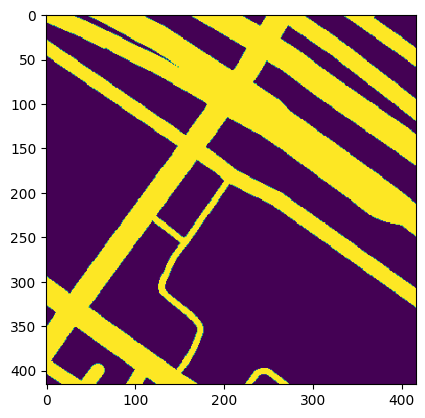

In [7]:
import numpy as np
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

print(original_data["images"][0].shape)
plt.imshow(original_data["images"][0])
plt.show()
print(original_data["masks"][0].shape)
plt.imshow(original_data["masks"][0])
plt.show()
item = original_data_set.__getitem__(0)
img_normal = np.swapaxes(item[0], 0, 2)
img_mask = np.swapaxes(item[1], 0, 2)
plt.imshow(img_normal)
plt.show()
plt.imshow(img_mask.squeeze(0))
plt.show()

### Split custom dataset into training and validation sets:

In [8]:
train_size = int(0.8 * len(custom_data_set))
valid_size = len(custom_data_set) - train_size
train_dataset, valid_dataset = random_split(custom_data_set, [train_size, valid_size])

batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

## Define the models that are used (ONLY RUN MODEL THAT SHOULD BE USED):

In [ ]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_depth=5,
    encoder_weights="imagenet",
    decoder_use_batchnorm=True,
    decoder_channels=(1024,512,256,64,16),
    decoder_attention_type=None,
    in_channels=3,
    classes=1,
    activation=None,
    aux_params=None
).to(device)

In [ ]:
model = smp.Unet(
    encoder_name="efficientnet-b5",
    encoder_depth=5,
    encoder_weights="imagenet",
    decoder_use_batchnorm=True,
    decoder_channels=(1024,512,256,64,16),
    decoder_attention_type=None,
    in_channels=3,
    classes=1,
    activation=None,
    aux_params=None
).to(device)

In [ ]:
model = smp.UnetPlusPlus(
    encoder_name="resnet34",
    encoder_depth=5,
    encoder_weights="imagenet",
    decoder_use_batchnorm=True,
    decoder_channels=(1024,512,256,64,16),
    decoder_attention_type=None,
    in_channels=3,
    classes=1,
    activation=None,
    aux_params=None
).to(device)

In [9]:
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b5",
    encoder_depth=5,
    encoder_weights="imagenet",
    decoder_use_batchnorm=True,
    decoder_channels=(1024,512,256,64,16),
    decoder_attention_type=None,
    in_channels=3,
    classes=1,
    activation=None,
    aux_params=None
).to(device)

#### Show some facts about the model in use:

In [10]:
print("Model loaded")
# how many trainable parameters does the model have?
print("Trainable parameters",sum(p.numel() for p in model.parameters() if p.requires_grad))
# how many total parameters does the model have?
print("Total parameters",sum(p.numel() for p in model.parameters()))

# percentage of trainable parameters
print("Percentage of trainable parameters: ")
print(sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()))

Model loaded
Trainable parameters 54679105
Total parameters 54679105
Percentage of trainable parameters: 
1.0


## Define loss functions:

In [11]:
class_weights = torch.tensor([1./0.13]).to(device)
bce_loss = nn.BCEWithLogitsLoss(weight=class_weights)
soft_bce_loss = smp.losses.SoftBCEWithLogitsLoss(weight=class_weights)

def dice_loss(logits,masks, smooth=1e-6):
    probs = torch.sigmoid(logits)
    probs_flat = probs.reshape(-1)
    masks_flat = masks.reshape(-1)
    
    intersection = (probs_flat * masks_flat).sum()
    union = probs_flat.sum() + masks_flat.sum()
    dice_coeff = (2.0 * intersection + smooth) / (union + smooth)
    return 1.0 - dice_coeff

def combined_loss_correct_dice(logits, masks, smooth=1e-6):
    # reshape the mask and predictions for the bce loss: 
    batch_size = logits.shape[0]
    logits_sq = logits.reshape((batch_size, 416*416))
    mask_sq = masks.reshape((batch_size, 416*416))
    
    return dice_loss(logits, masks, smooth=smooth) + bce_loss(logits_sq, mask_sq)

## Define performance metrics:

In [12]:
def mean_f1_score_from_logits(pred, mask):
    pred_classes = torch.round(torch.sigmoid(pred))
    return mean_f1_score_from_classes(mask, pred_classes)

def mean_f1_score_from_classes(preds, masks):
    b_size = masks.shape[0]
    f1_acc = 0.
    size = torch.prod(torch.tensor(masks.shape[1:]))
    for i in range(b_size):
        mask = masks[i]
        pred = preds[i]
        f1_acc = f1_acc + multiclass_f1_score(pred.reshape((size)), mask.reshape((size)))
    mean_f1 = f1_acc/b_size
    return mean_f1

def mean_iou_from_logits(pred, mask):
    pred_classes = torch.round(torch.sigmoid(pred))
    return mean_iou_from_classes(mask, pred_classes)

def mean_iou_from_classes(preds, masks):
    b_size = masks.shape[0]
    iou_acc = 0.
    size = torch.prod(torch.tensor(masks.shape[1:]))
    for i in range(b_size):
        mask = masks[i].reshape((size)).bool()
        pred = preds[i].reshape((size)).bool()
        intersection = (pred & mask).float().sum()
        union = (pred | mask).float().sum()
        iou = (intersection + 1e-10) / (union + 1e-10)
        iou_acc = iou_acc + iou
    mean_iou = iou_acc / b_size
    return mean_iou

## Define the optimizer and scheduler:

In [13]:
# Define optimizer and scheduler
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0005)])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=10, verbose=True, threshold=1e-5)

/opt/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## Time to train:

##### If needed, load the model from a specific model checkpoint by uncommenting the following line:

In [ ]:
model.load_state_dict(torch.load("model/best_model_0.pth"))

In [14]:
loss_scores = []
f1_scores = []
iou_scores = []

#### First, we train on the custom dataset:

In [16]:
# Training loop
for epoch in range(10):
    model.train()
    average_loss = 0
    f1_score = 0
    iou_score = 0

    for data in tqdm.tqdm(train_loader, leave=False):
        x, y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        y_pred = model.forward(x)

        loss = combined_loss_correct_dice(y_pred, y)
        loss.backward()
        optimizer.step()

        # Update loss, f1 and iou
        average_loss += loss.item()
        f1_score += mean_f1_score_from_logits(y_pred, y)
        iou_score += mean_iou_from_logits(y_pred, y)

    # Print training stats for the current epoch
    print(f"Epoch: {epoch}, Training Loss: {average_loss / len(train_loader)}, F1: {f1_score / len(train_loader)}, IOU: {iou_score / len(train_loader)}")

    torch.save(model.state_dict(), f"model/best_model_{epoch}.pth")

    # Validation loop
    model.eval()
    average_loss = 0
    f1_score = 0
    iou_score = 0

    for x, y in tqdm.tqdm(valid_loader):
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            y_pred = model.forward(x)
            loss = combined_loss_correct_dice(y_pred, y)

        # Update loss, f1 and iou
        average_loss += loss.item()
        f1_score += mean_f1_score_from_logits(y_pred, y)
        iou_score += mean_iou_from_logits(y_pred, y)

    # Print validation stats for the current epoch
    val_loss = average_loss / len(valid_loader)
    val_f1 = f1_score / len(valid_loader)
    val_iou = iou_score / len(valid_loader)
    print(f"Epoch: {epoch}, Validation Loss: {val_loss}, F1: {val_f1}, IOU: {val_iou}")
    loss_scores.append(val_loss)
    f1_scores.append(val_f1.cpu().item())
    iou_scores.append(val_f1.cpu().item())
    
    scheduler.step(val_loss)

Epoch: 0, Training Loss: 1.8816670352268474, F1: 0.9240975975990295, IOU: 0.5611620545387268


100%|██████████| 2331/2331 [01:08<00:00, 34.26it/s]


Epoch: 0, Validation Loss: 1.5626746644947163, F1: 0.9384457468986511, IOU: 0.6286390423774719


Epoch: 1, Training Loss: 1.5440234339908365, F1: 0.9377894401550293, IOU: 0.6260144710540771


100%|██████████| 2331/2331 [01:06<00:00, 34.84it/s]


Epoch: 1, Validation Loss: 1.474052529614251, F1: 0.9418224692344666, IOU: 0.6498542428016663


Epoch: 2, Training Loss: 1.448153632415843, F1: 0.9417088627815247, IOU: 0.6441910266876221


100%|██████████| 2331/2331 [01:07<00:00, 34.74it/s]


Epoch: 2, Validation Loss: 1.3911546018439678, F1: 0.9447668194770813, IOU: 0.6581456065177917


Epoch: 3, Training Loss: 1.384367109911052, F1: 0.9442043900489807, IOU: 0.6563792824745178


100%|██████████| 2331/2331 [01:12<00:00, 32.30it/s]


Epoch: 3, Validation Loss: 1.3365574935471127, F1: 0.9466515779495239, IOU: 0.6746578216552734


Epoch: 4, Training Loss: 1.3340873680868992, F1: 0.9461273550987244, IOU: 0.6663267612457275


100%|██████████| 2331/2331 [01:16<00:00, 30.40it/s]


Epoch: 4, Validation Loss: 1.2980542587062822, F1: 0.9486111998558044, IOU: 0.6786190867424011


Epoch: 5, Training Loss: 1.308456918860888, F1: 0.9472402930259705, IOU: 0.6729126572608948


100%|██████████| 2331/2331 [01:13<00:00, 31.85it/s]


Epoch: 5, Validation Loss: 1.2966993950253032, F1: 0.9482288956642151, IOU: 0.6784970760345459


Epoch: 6, Training Loss: 1.2852804863420952, F1: 0.948008120059967, IOU: 0.6773167252540588


100%|██████████| 2331/2331 [01:14<00:00, 31.49it/s]


Epoch: 6, Validation Loss: 1.2766807264189308, F1: 0.9494308233261108, IOU: 0.6875391006469727


Epoch: 7, Training Loss: 1.241519971283767, F1: 0.9496658444404602, IOU: 0.6856407523155212


100%|██████████| 2331/2331 [01:13<00:00, 31.59it/s]


Epoch: 7, Validation Loss: 1.2512535222900727, F1: 0.950176477432251, IOU: 0.6899209022521973


Epoch: 8, Training Loss: 1.2240972969870785, F1: 0.950377345085144, IOU: 0.6901727914810181


100%|██████████| 2331/2331 [01:38<00:00, 23.78it/s]


Epoch: 8, Validation Loss: 1.27107496076339, F1: 0.9491719603538513, IOU: 0.6900111436843872


Epoch: 9, Training Loss: 1.2067668945476133, F1: 0.9509758949279785, IOU: 0.6935849785804749


100%|██████████| 2331/2331 [01:36<00:00, 24.11it/s]

Epoch: 9, Validation Loss: 1.2450661252926778, F1: 0.9508054852485657, IOU: 0.6911076903343201


UPP-Model, SoftBCELoss:\
The lowest training value is 0.8790411872128463 at index 12.\
The largest f1-score is 0.9565524458885193 at index 44.\
The largest iou-score is 0.7358250021934509 at index 27.

### Show a visual representation of the intermediate training process:

torch.Size([3, 416, 416])
torch.Size([1, 416, 416])


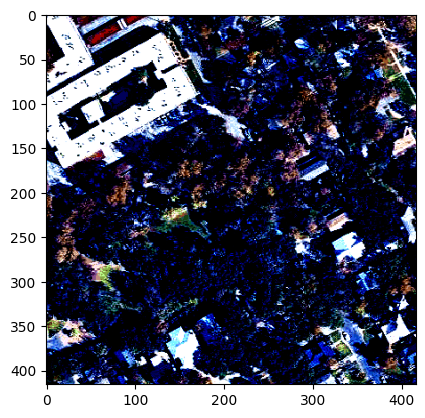

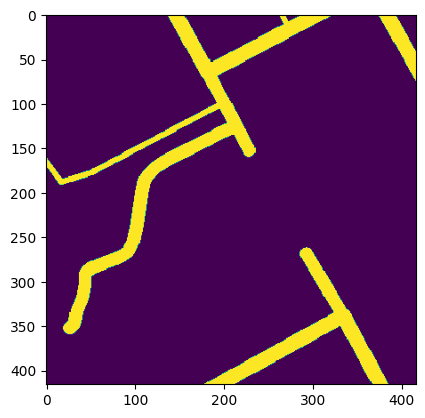

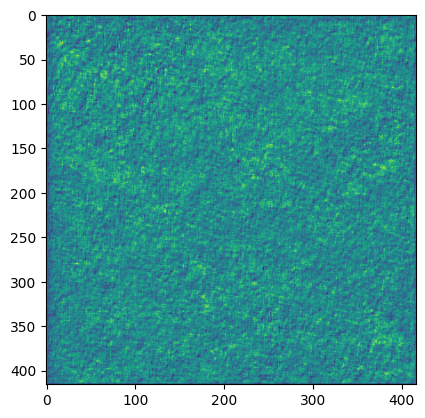

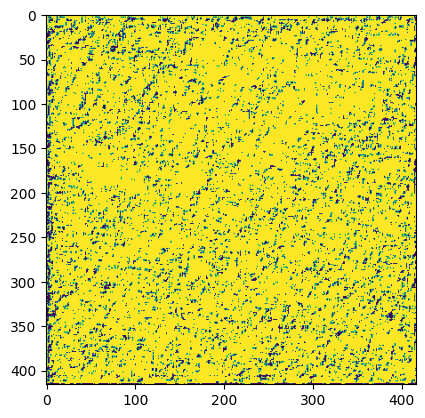

In [15]:
import matplotlib.pyplot as plt
import numpy as np 

item = valid_loader.dataset[0]
image_visual = item[0]
mask_visual = item[1]
print(image_visual.shape)
print(mask_visual.shape)
img_normal = np.swapaxes(image_visual, 0, 2)
img_mask = np.swapaxes(mask_visual, 0, 2)
plt.imshow(img_normal)
plt.show()
plt.imshow(img_mask)
plt.show()
model.eval()
pred = None
with torch.no_grad():
    image = image_visual.unsqueeze(0).to(device)
    pred = model(image).cpu()
plt.imshow(pred.squeeze())
plt.show()
plt.imshow(torch.round(torch.sigmoid(pred.squeeze())))
plt.show()

##### If needed, load the model from a specific model checkpoint by uncommenting the following line:

In [17]:
model.load_state_dict(torch.load("model_upp_sbce/model_0_0_1/best_model_7.pth"))

<All keys matched successfully>

### Split original Kaggle dataset into training and validation sets:

In [18]:
train_size = int(0.9 * len(original_data_set))
valid_size = len(original_data_set) - train_size
gen = torch.Generator()
gen.manual_seed(0)
train_dataset, valid_dataset = random_split(original_data_set, [train_size, valid_size], generator=gen)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [22]:
print(len(valid_loader))
print(len(train_loader))

29
23


In [19]:
# Training loop
for epoch in range(10):
    model.train()
    average_loss = 0
    f1_score = 0
    iou_score = 0

    for data in tqdm.tqdm(train_loader, leave=False):
        x, y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        y_pred = model.forward(x)

        loss = soft_bce_loss(y_pred, y)
        loss.backward()
        optimizer.step()

        # Update loss, f1 and iou
        average_loss += loss.item()
        f1_score += mean_f1_score_from_logits(y_pred, y)
        iou_score += mean_iou_from_logits(y_pred, y)

    # Print training stats for the current epoch
    print(f"Epoch: {epoch}, Training Loss: {average_loss / len(train_loader)}, F1: {f1_score / len(train_loader)}, IOU: {iou_score / len(train_loader)}")

    torch.save(model.state_dict(), f"model/best_model_finetune_{epoch}.pth")

    # Validation loop
    model.eval()
    average_loss = 0
    f1_score = 0
    iou_score = 0

    for x, y in tqdm.tqdm(valid_loader):
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            y_pred = model.forward(x)
            loss = soft_bce_loss(y_pred, y)

        # Update loss, f1 and iou
        average_loss += loss.item()
        f1_score += mean_f1_score_from_logits(y_pred, y)
        iou_score += mean_iou_from_logits(y_pred, y)

    # Print validation stats for the current epoch
    val_loss = average_loss / len(valid_loader)
    val_f1 = f1_score / len(valid_loader)
    val_iou = iou_score / len(valid_loader)
    print(f"Epoch: {epoch}, Validation Loss: {val_loss}, F1: {val_f1}, IOU: {val_iou}")
    loss_scores.append(val_loss)
    f1_scores.append(val_f1.cpu().item())
    iou_scores.append(val_f1.cpu().item())
    
    scheduler.step(val_loss)

Epoch: 0, Training Loss: 1.302341110431231, F1: 0.9345200657844543, IOU: 0.663117527961731


100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Epoch: 0, Validation Loss: 1.1776172041893005, F1: 0.9391024708747864, IOU: 0.7213509678840637


Epoch: 1, Training Loss: 1.0757330082930052, F1: 0.9448375701904297, IOU: 0.7070493102073669


100%|██████████| 15/15 [00:01<00:00, 10.20it/s]


Epoch: 1, Validation Loss: 1.1219586114088693, F1: 0.9449831247329712, IOU: 0.7433665990829468


Epoch: 2, Training Loss: 0.9847589135169983, F1: 0.9486285448074341, IOU: 0.7238692045211792


100%|██████████| 15/15 [00:01<00:00, 10.26it/s]


Epoch: 2, Validation Loss: 1.1345012307167053, F1: 0.9452327489852905, IOU: 0.7470453977584839


Epoch: 3, Training Loss: 0.9333211642045242, F1: 0.9511038064956665, IOU: 0.7380751371383667


100%|██████████| 15/15 [00:01<00:00, 10.18it/s]


Epoch: 3, Validation Loss: 1.1087268590927124, F1: 0.9434074759483337, IOU: 0.7453014850616455


Epoch: 4, Training Loss: 0.9213079512119293, F1: 0.9525235295295715, IOU: 0.7453308701515198


100%|██████████| 15/15 [00:01<00:00, 10.74it/s]


Epoch: 4, Validation Loss: 1.1739485104878744, F1: 0.9416473507881165, IOU: 0.7374541759490967


Epoch: 5, Training Loss: 0.8477111114905431, F1: 0.9556767344474792, IOU: 0.7584608793258667


100%|██████████| 15/15 [00:01<00:00, 10.54it/s]


Epoch: 5, Validation Loss: 1.1499423841635386, F1: 0.943485677242279, IOU: 0.740413248538971


Epoch: 6, Training Loss: 0.7999009856810937, F1: 0.9578471779823303, IOU: 0.7707518339157104


100%|██████████| 15/15 [00:01<00:00, 10.46it/s]


Epoch: 6, Validation Loss: 1.1783763786156973, F1: 0.943760335445404, IOU: 0.7483739852905273


Epoch: 7, Training Loss: 0.766337092106159, F1: 0.9594903588294983, IOU: 0.7770658731460571


100%|██████████| 15/15 [00:01<00:00, 10.14it/s]


Epoch: 7, Validation Loss: 1.1334257880846659, F1: 0.943997323513031, IOU: 0.7499774098396301


Epoch: 8, Training Loss: 0.7185887923607459, F1: 0.9616062641143799, IOU: 0.7867562770843506


100%|██████████| 15/15 [00:01<00:00, 10.30it/s]


Epoch: 8, Validation Loss: 1.1778136213620505, F1: 0.9446295499801636, IOU: 0.7519016861915588


Epoch: 9, Training Loss: 0.702217990389237, F1: 0.962975800037384, IOU: 0.7927975058555603


100%|██████████| 15/15 [00:01<00:00, 10.34it/s]

Epoch: 9, Validation Loss: 1.232009611527125, F1: 0.9432730078697205, IOU: 0.7476456165313721


Baselines (F1-score):
- Unet Efficient: 0.9400148987770081 (Validation), 0.93428 (Kaggle)
- UPP Efficient: 0.936101496219635 (Validation), 0.93273 (Kaggle)
- Unet ResNet: 0.9320721626281738 (Validation), 0.92591 (Kaggle)
- UPP ResNet: 0.9340260028839111 (Validation), 0.92733 (Kaggle)

# Prepare the Kaggle Submission:

In [20]:
from custom_datasets import Sat_Only_Image_UPP_preprocessed
kaggle_submission_images = load_test_images()
submission_data_set = Sat_Only_Image_UPP_preprocessed(kaggle_submission_images, upp_preprocess=preprocess_input)
submission_dataloader = DataLoader(submission_data_set, batch_size=1, shuffle=False, drop_last=False, num_workers=4, persistent_workers=True)

In [21]:
model.eval()
predictions = []
with torch.no_grad():
    for image in tqdm.tqdm(submission_dataloader):
        image = image.to(device)
        pred = model(image).cpu()
        predictions.append(pred)

100%|██████████| 144/144 [00:23<00:00,  6.05it/s]


In [22]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np 
from mask_to_submission import make_submission
counter = 144
path = "submission/model/"
final_pred_images = []
for sp in predictions:
    pred_image = torch.round(torch.sigmoid(sp.squeeze()))
    pred = F.interpolate(pred_image.unsqueeze(0).unsqueeze(0), size=(400,400), mode='nearest')
    pred = pred.squeeze().numpy()
    pred = (pred * 255).astype(np.uint8)
    pred = np.stack([pred, pred, pred],axis=2)
    plt.imsave(path+"mask_"+str(counter)+".png", pred)
    counter += 1
    final_pred_images.append(pred)

make_submission("submission_final.csv", path, foreground_threshold= 0.25)

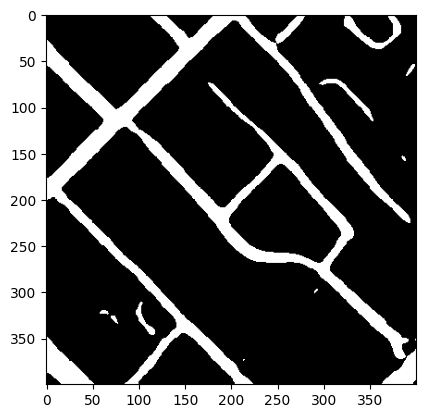

In [23]:
plt.imshow(final_pred_images[0])
plt.show()